<a href="https://colab.research.google.com/github/rematchka/NLP-Coding-Challenge/blob/main/Coding_Challenge_for_Fatima_Fellowship.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fatima Fellowship Quick Coding Challenge (Pick 1)

Thank you for applying to the Fatima Fellowship. To help us select the Fellows and assess your ability to do machine learning research, we are asking that you complete a short coding challenge. Please pick **1 of these 5** coding challenges, whichever is most aligned with your interests. 

**Due date: 1 week**

**How to submit**: Please make a copy of this colab notebook, add your code and results, and submit your colab notebook to the submission link below. If you have never used a colab notebook, [check out this video](https://www.youtube.com/watch?v=i-HnvsehuSw).

**Submission link**: https://airtable.com/shrXy3QKSsO2yALd3

# 2. Deep Learning for NLP

**Fake news classifier**: Train a text classification model to detect fake news articles!

* Download the dataset here: https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset
* Develop an NLP model for classification that uses a pretrained language model
* Finetune your model on the dataset, and generate an AUC curve of your model on the test set of your choice. 
* [Upload the the model to the Hugging Face Hub](https://huggingface.co/docs/hub/adding-a-model), and add a link to your model below.
* *Answer the following question*: Look at some of the news articles that were classified incorrectly. Please explain what you might do to improve your model's performance on these news articles in the future (you do not need to impelement these suggestions)

### Load librariesand install libraries

In [ ]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 11.7 MB/s 
     |████████████████████████████████| 6.5 MB 12.8 MB/s 
     |████████████████████████████████| 596 kB 10.8 MB/s 
     |████████████████████████████████| 77 kB 5.4 MB/s 
     |████████████████████████████████| 895 kB 36.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install scikit-plot

In [ ]:
import os
import gc
import copy
import time
import random
import string
import re

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


# Utils
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_curve
# Compute ROC curve and ROC area for each class
import scikitplot as skplt

# For Transformer Models
from transformers import AutoTokenizer, AutoModel, AdamW
from transformers import AutoConfig
from transformers import get_scheduler



# visualization 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline
# NLP libraries as NLTK
from collections import defaultdict
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Mount Drive and load the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
true_df = pd.read_csv('/content/drive/MyDrive/Fatima Fellowship Task/True.csv')
fake_df = pd.read_csv('/content/drive/MyDrive/Fatima Fellowship Task/Fake.csv')

In [ ]:
# adding label
true_df["label"] = [1]*len(true_df) 
fake_df["label"] = [0]*len(fake_df)

In [ ]:
# concatenate true & fake articles together
df = pd.concat([true_df, fake_df]).sample(frac=1).reset_index(drop=True)
# # drop duplicates
df.drop_duplicates(inplace=True)

# empty rows
df.dropna(inplace=True)

### Investigate The data  

##### Check If date might affect classification 

In [ ]:
## Extract Year from Data column
df['year']=df['date'].str[-5:]


In [ ]:
df['year'].unique()

array(['2017 ', '2016 ', ' 2017', ' 2016', ' 2015', 'eb-18', 'dier/',
       'd.jpg', 'left/', 't.jpg', 'ideo]', '-pie/'], dtype=object)

It seems that the date column is not well formated anc ontain some useless information, Therefore we could descard this column

##### Invetigating Article/Title column

Text(0, 0.5, 'Distribution of words in the news text')

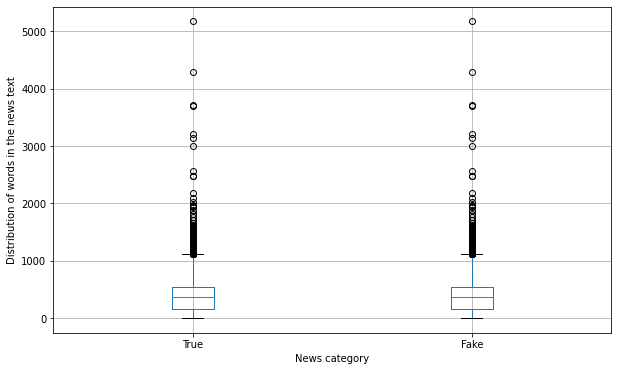

In [ ]:
# get number of words in the data
def text_length(text):
    word_count = 0
    for word in text.split(" "):
        word_count += 1
    return word_count

true_words_count = true_df['text'].apply(text_length)
fake_words_count = fake_df['text'].apply(text_length)

words_count = pd.DataFrame({'True': true_words_count, 'Fake': true_words_count})

plt.figure(figsize=(10, 6))
words_count.boxplot()
plt.xlabel('News category')
plt.ylabel('Distribution of words in the news text')

Surprisingly fake news have more words than true ones. Hypothetically, this can be explained by the desire of fake news to convince the audience in their reliablity and hence, they use more words and tricks to do it. However, at the same the true news should give an extensive explanation of their articles to the audience. Hence, some mystery occures here.

Text(0, 0.5, 'Distribution of words in the news title')

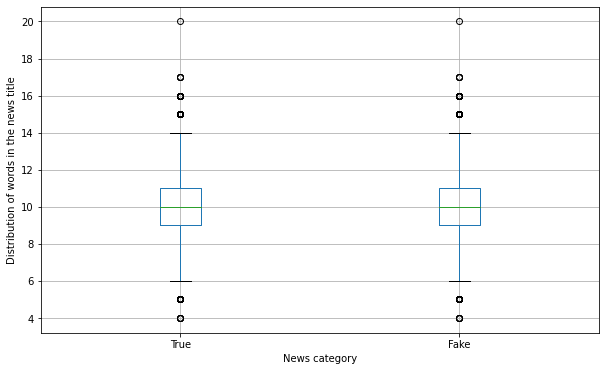

In [ ]:
true_words_count = true_df['title'].apply(text_length)
fake_words_count = fake_df['title'].apply(text_length)

words_count = pd.DataFrame({'True': true_words_count, 'Fake': true_words_count})

plt.figure(figsize=(10, 6))
words_count.boxplot()
plt.xlabel('News category')
plt.ylabel('Distribution of words in the news title')

In [ ]:
stopwords = stopwords.words('english')


# create a corpuse of words in the data.
def create_corpuse(data, column_name):
    words_by_frequency = defaultdict(int)

    for title in data['{0}'.format(column_name)]:
        for word in title.lower().split(' '):
            if word not in stopwords:
                words_by_frequency[word] += 1

    return sorted(words_by_frequency.items(), key=lambda x: x[1], reverse=True)

counter_words_title_true = create_corpuse(true_df, 'title')
counter_words_title_fake = create_corpuse(fake_df, 'title')

counter_words_text_true = create_corpuse(true_df, 'text')
counter_words_text_fake = create_corpuse(fake_df, 'text')

In [ ]:
# plot the most frequent words in the data.
def most_frequent_words_barplot(true_words, fake_words, part = 'titles'):
    fig, ax = plt.subplots(1, 2, figsize = (16, 8)) 
    sns.barplot(x=[x[1] for x in true_words[:30]], y =[x[0] for x in true_words[:30]], palette='Blues', ax = ax[0])
    sns.barplot(x=[x[1] for x in fake_words[:30]], y =[x[0] for x in fake_words[:30]], palette='Reds', ax = ax[1])

    ax[0].title.set_text("30 most common words in true news articles {0}".format(part))
    ax[1].title.set_text("30 most common words in fake news articles {0}".format(part))

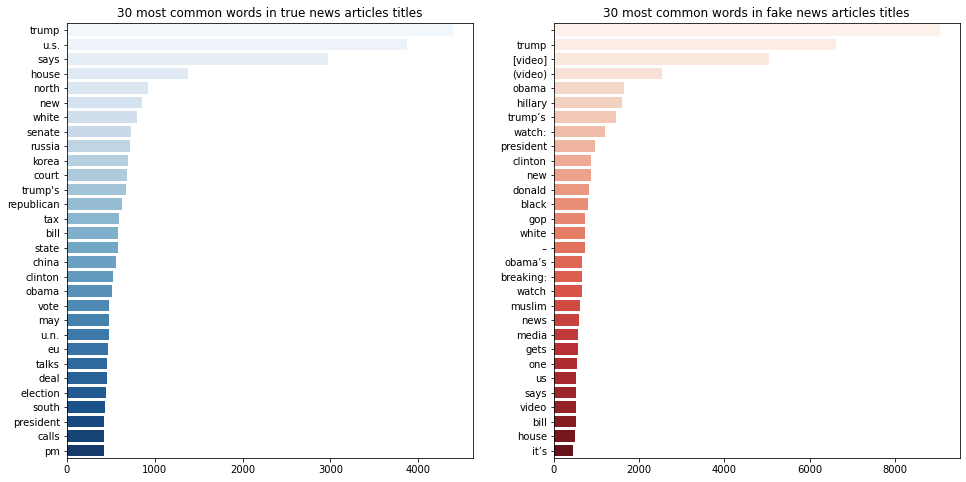

In [ ]:
# Most frequent words in titles of true vs fake news.
most_frequent_words_barplot(counter_words_title_true, counter_words_title_fake)

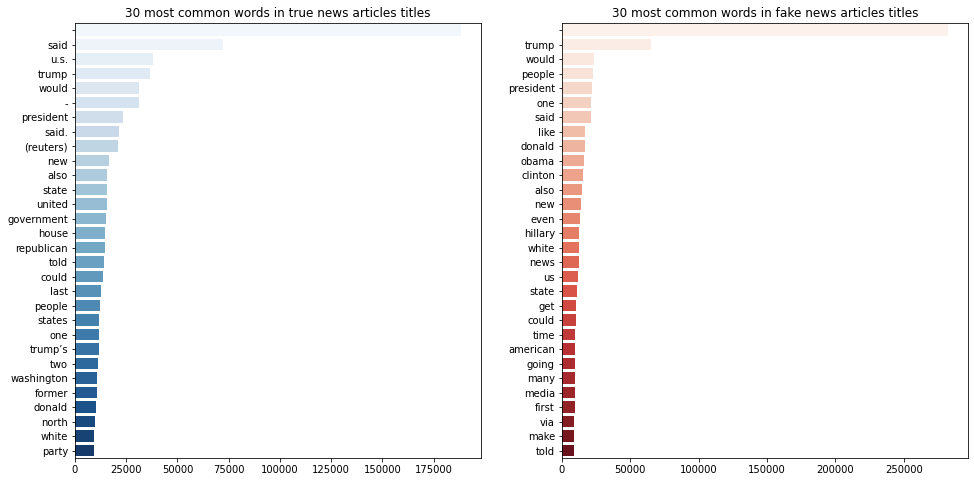

In [ ]:
# Most frequent words in texts of true vs fake news.
most_frequent_words_barplot(counter_words_text_true, counter_words_text_fake)

It seems that the  two plots above don't show any apparent difference between the titles of the news or the article itself

In [ ]:
# some popular news agencies names 
# get the number of 'element' in the data
def find_text_elements(data, column_name, element):
    count_element = 0
    re_element = re.compile(element)
    for text in data['{0}'.format(column_name)]:
        count_element += len(re.findall(re_element, text.lower()))
    return count_element

articles = {'the washington post': [0, 0], 'cnn': [0, 0], 'bbc': [0, 0], 'reuters': [0, 0], 
            'fox news': [0, 0], 'the new york times': [0, 0], 'nbc': [0, 0]}
for key, _ in articles.items():
    true_value = find_text_elements(true_df, 'text', element=key)
    fake_value = find_text_elements(fake_df, 'text', element=key)
    articles[key] = true_value, fake_value
    


<Figure size 720x432 with 0 Axes>

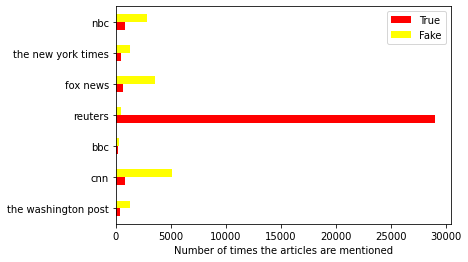

In [ ]:
articles_count = pd.DataFrame(articles)


plt.figure(figsize=(10, 6))
articles_count.T.plot(kind='barh', colormap='autumn')
plt.xlabel('Number of times the articles are mentioned');
plt.legend(['True', 'Fake']);

It seems with word reuters in the article we classify articles into fake vs true

In [ ]:

articles = {'the washington post': [0, 0], 'cnn': [0, 0], 'bbc': [0, 0], 'reuters': [0, 0], 
            'fox news': [0, 0], 'the new york times': [0, 0], 'nbc': [0, 0]}
for key, _ in articles.items():
    true_value = find_text_elements(true_df, 'title', element=key)
    fake_value = find_text_elements(fake_df, 'title', element=key)
    articles[key] = true_value, fake_value
    


<Figure size 720x432 with 0 Axes>

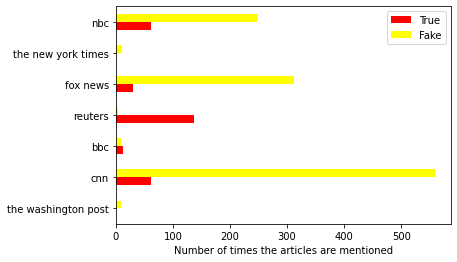

In [ ]:
articles_count = pd.DataFrame(articles)
plt.figure(figsize=(10, 6))
articles_count.T.plot(kind='barh', colormap='autumn')
plt.xlabel('Number of times the articles are mentioned');
plt.legend(['True', 'Fake']);

For the title it seems having word CNN is enough to classify True vs fake articles

#### Next step is to investigate the topic column

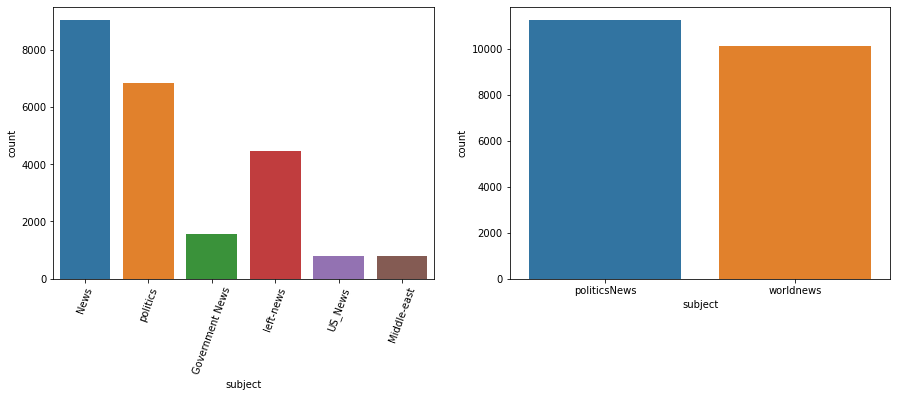

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.countplot('subject', data=fake_df)
plt.xticks(rotation =70)

plt.subplot(1, 2, 2)
sns.countplot('subject', data=true_df)
plt.show()

Left graph indicates Topics for Fake articles, while right graph indicates topics for True articles, it seems that any Topic/subject of type Politicsnews or worldnews is non-fake article while any  other subject/topic is Fake article, May be there is a bias in the data. Therefore it's a good option not to use it in building the model

#### Conclusion about the data


The dataset has many features that point to bias towards fake news, apparently a poorly structured dataset that does not allow you to raise more consistent information in relation to real characteristics that fake news can present

### Split dataset into train-validation test

In [ ]:
train, validate, test = \
              np.split(df.sample(frac=1, random_state=42), 
                       [int(.6*len(df)), int(.8*len(df))])

### Model Building

In [ ]:
DATA_COLUMN='text'
LABEL_COLUMN='label'
MODEL_NAME='bert-base-uncased'
tokenizer= AutoTokenizer.from_pretrained(MODEL_NAME)


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [ ]:
CONFIG = {"seed": 2021,
          "epochs": 3,
          "train_batch_size": 16,
          "valid_batch_size": 64,
          "max_length": 256,
          "learning_rate": 1e-4,
          "scheduler": 'CosineAnnealingLR',
          "min_lr": 1e-6,
          "T_max": 500,
          "weight_decay": 1e-6,
          "n_fold": 5,
          "n_accumulate": 1,
          "num_classes": 1,
          "margin": 0.5,
          "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
          }

In [ ]:
class TrainDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df[DATA_COLUMN].values
        self.label=df[LABEL_COLUMN].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs_text = self.tokenizer.encode_plus(
                                text,
                                truncation=True,
                                add_special_tokens=True,
                                max_length=self.max_len,
                                padding='max_length'
                            )
        
                            
        target = self.label[index]        
        text_ids = inputs_text['input_ids']
        text_mask = inputs_text['attention_mask']      
              
        
        return {
            
            'text_ids': torch.tensor(text_ids, dtype=torch.long),
            'text_mask': torch.tensor(text_mask, dtype=torch.long),
            'target': torch.tensor(target, dtype=torch.float)
        }


In [ ]:
class Fake_Real_Model_Arch(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.bert = AutoModel.from_pretrained(MODEL_NAME)        
        num_classes = 2  # number of targets to predict
        embedding_dim = 768   # length of embedding dim        
        self.fc1 = nn.Linear(embedding_dim, num_classes)
        self.softmax = nn.Softmax()

    def forward(self, text_id, text_mask):
        outputs= self.bert(text_id, attention_mask=text_mask)        
        outputs = outputs[1]  # get hidden layers       
        logit = self.fc1(outputs)
        return self.softmax(logit)

In [ ]:
def criterion(outputs,  targets):
    criterion = torch.nn.CrossEntropyLoss()
    loss = criterion(outputs, targets)
    return loss

In [ ]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        
        text_ids = data['text_ids'].to(device, dtype = torch.long)
        text_mask = data['text_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.float)
        targets = F.one_hot(targets.to(torch.int64), 2).to(torch.float32)
        
        batch_size = text_ids.size(0)

        outputs = model(text_ids, text_mask)
             
     

        
        loss = criterion(outputs, targets)
        loss = loss / CONFIG['n_accumulate']
        loss.backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size

       
      
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss

In [ ]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        
        text_ids = data['text_ids'].to(device, dtype = torch.long)
        text_mask = data['text_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.float)
        targets = F.one_hot(targets.to(torch.int64), 2).to(torch.float32)
        
        batch_size = text_ids.size(0)

        outputs = model(text_ids, text_mask)
      
        
        
        loss = criterion(outputs, targets)
        

        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])   
    
    gc.collect()
    
    return epoch_loss

In [ ]:
def run_training(model, optimizer, scheduler, device, num_epochs):
    # To automatically log gradients
    
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_loss = np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss = valid_one_epoch(model, valid_loader, device=CONFIG['device'], 
                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        
       
        
        # deep copy the model
        if val_epoch_loss <= best_epoch_loss:
            print(f"Validation Loss Improved ({best_epoch_loss} ---> {val_epoch_loss})")
            best_epoch_loss = val_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"/content/drive/MyDrive/Fatima Fellowship Task/Model_weights/model_roberta.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print("Model Saved")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss: {:.4f}".format(best_epoch_loss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [ ]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None

    
        
    return scheduler

In [ ]:
def prepare_loaders():   
    
    train_dataset = TrainDataset(train, tokenizer=tokenizer, max_length=CONFIG['max_length'])
    valid_dataset = TrainDataset(validate, tokenizer=tokenizer, max_length=CONFIG['max_length'])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], 
                              num_workers=2, shuffle=False, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], 
                              num_workers=2, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

## FineTune Model

In [ ]:
import gc
gc.collect()

4087

In [ ]:
# Create Dataloaders
train_loader, valid_loader = prepare_loaders()
model = Fake_Real_Model_Arch()
model.to(CONFIG['device'])
torch.cuda.empty_cache()

# Define Optimizer and Scheduler

param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 
     'weight_decay': 0.0001},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 
     'weight_decay': 0.0}
    ]  

optimizer = AdamW(optimizer_parameters, lr=CONFIG['learning_rate'])


model, history = run_training(model, optimizer, fetch_scheduler(optimizer),
                              device=CONFIG['device'],
                              num_epochs=CONFIG['epochs'],
                              )


del model, history, train_loader, valid_loader
_ = gc.collect()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a

[INFO] Using GPU: Tesla K80



  0%|          | 0/1675 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app
100%|██████████| 140/140 [04:14<00:00,  1.82s/it, Epoch=1, LR=2.8e-5, Valid_Loss=0.319]


Validation Loss Improved (inf ---> 0.318861868103283)
Model Saved



100%|██████████| 140/140 [04:14<00:00,  1.82s/it, Epoch=2, LR=2.14e-5, Valid_Loss=0.319]


Validation Loss Improved (0.318861868103283 ---> 0.3185959299503223)
Model Saved



100%|██████████| 140/140 [04:14<00:00,  1.81s/it, Epoch=3, LR=9.94e-5, Valid_Loss=0.842]



Training complete in 2h 2m 16s
Best Loss: 0.3186


## Inference

In [ ]:
import transformers
class Fake_Real_Model_Arch_test(transformers.PreTrainedModel):
    def __init__(self,bert):
        super(Fake_Real_Model_Arch_test,self).__init__(config=AutoConfig.from_pretrained(MODEL_NAME))
        
        self.bert = bert        
        num_classes = 2  # number of targets to predict
        embedding_dim = 768   # length of embedding dim        
        self.fc1 = nn.Linear(embedding_dim, num_classes)
        self.softmax = nn.Softmax()

    def forward(self, text_id, text_mask):
        outputs= self.bert(text_id, attention_mask=text_mask)        
        outputs = outputs[1]  # get hidden layers       
        logit = self.fc1(outputs)
        return self.softmax(logit)

In [ ]:
@torch.no_grad()
def test_fn(model, dataloader, device):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    PREDS = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        ids = data['text_ids'].to(device, dtype = torch.long)
        mask = data['text_mask'].to(device, dtype = torch.long)
        
        outputs = model(ids, mask)
        PREDS.append(outputs.detach().cpu().numpy()) 
    
    PREDS = np.concatenate(PREDS)
    gc.collect()
    
    return PREDS

In [ ]:
test_dataset = TrainDataset(test, tokenizer=tokenizer, max_length=CONFIG['max_length'])
test_loader = DataLoader(test_dataset, batch_size=CONFIG['valid_batch_size'], 
                              num_workers=2, shuffle=False, pin_memory=True)

In [ ]:
def inference(model_paths, dataloader, device):
    final_preds = []
    for i, path in enumerate(model_paths):
        model = Fake_Real_Model_Arch_test(AutoModel.from_pretrained(MODEL_NAME))
        model.to(CONFIG['device'])
        model.load_state_dict(torch.load(path))
        
        print(f"Getting predictions for model {i+1}")
        preds = test_fn(model, dataloader, device)
        final_preds.append(preds)
    
    final_preds = np.array(final_preds)
    final_preds_probabolity = np.mean(final_preds, axis=0)
    final_preds= np.argmax(final_preds_probabolity,axis=1)
    return final_preds,final_preds_probabolity

In [ ]:
MODEL_PATH_=['/content/drive/MyDrive/Fatima Fellowship Task/Model_weights/model_roberta.bin']
preds,prob = inference(MODEL_PATH_, test_loader, CONFIG['device'])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Getting predictions for model 1


  0%|          | 0/140 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()
100%|██████████| 140/140 [04:13<00:00,  1.81s/it]


### inference using hugging Face

In [ ]:
def inference_huggingFace( dataloader, device):
    final_preds = []
   
    model =  Fake_Real_Model_Arch_test(AutoModel.from_pretrained("rematchka/Bert_fake_news_detection"))
    model.to(CONFIG['device'])
    
    
    print("Getting predictions for model")
    preds = test_fn(model, dataloader, device)
    final_preds.append(preds)
    
    final_preds = np.array(final_preds)
    final_preds_probabolity = np.mean(final_preds, axis=0)
    final_preds= np.argmax(final_preds_probabolity,axis=1)
    return final_preds

In [ ]:
tokenizer_ = AutoTokenizer.from_pretrained(MODEL_NAME)
test_dataset = TrainDataset(test, tokenizer=tokenizer_, max_length=CONFIG['max_length'])
test_loader = DataLoader(test_dataset, batch_size=CONFIG['valid_batch_size'], 
                              num_workers=2, shuffle=False, pin_memory=True)

In [ ]:
prediction=inference_huggingFace(test_loader, CONFIG['device'])

Some weights of the model checkpoint at rematchka/Bert_fake_news_detection were not used when initializing BertModel: ['fc1.bias', 'fc1.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Getting predictions for model


  0%|          | 0/140 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()
100%|██████████| 140/140 [04:13<00:00,  1.81s/it]


#### Classification Report

In [ ]:
from sklearn.metrics import jaccard_score,f1_score,accuracy_score,recall_score,precision_score,classification_report
def print_statistics(y, y_pred):
    accuracy = accuracy_score(y, y_pred)
    precision =precision_score(y, y_pred, average='weighted')
    recall = recall_score(y, y_pred, average='weighted')
    f_score = f1_score(y, y_pred, average='weighted')
    print('Accuracy: %.3f\nPrecision: %.3f\nRecall: %.3f\nF_score: %.3f\n'
          % (accuracy, precision, recall, f_score))
    print(classification_report(y, y_pred))
    return accuracy, precision, recall, f_score

In [ ]:
print(print_statistics(test[LABEL_COLUMN],preds))

Accuracy: 0.995
Precision: 0.995
Recall: 0.995
F_score: 0.995

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4675
           1       0.99      1.00      0.99      4263

    accuracy                           0.99      8938
   macro avg       0.99      0.99      0.99      8938
weighted avg       0.99      0.99      0.99      8938

(0.9948534347728798, 0.9948666172341039, 0.9948534347728798, 0.9948539885713076)


In [ ]:
print(print_statistics(test[LABEL_COLUMN],prediction))

Accuracy: 0.995
Precision: 0.995
Recall: 0.995
F_score: 0.995

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4675
           1       0.99      1.00      0.99      4263

    accuracy                           0.99      8938
   macro avg       0.99      0.99      0.99      8938
weighted avg       0.99      0.99      0.99      8938

(0.9948534347728798, 0.9948666172341039, 0.9948534347728798, 0.9948539885713076)


#### AUC Curve

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(preds, np.max(prob,axis=1))

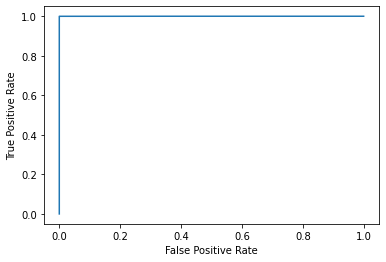

In [ ]:
#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Error Analysis

In [ ]:
index_wrong=[]
for i in range(len(test)):
  if int(test[LABEL_COLUMN].iloc[i])!=int(preds[i]):
    index_wrong.append(i)

df_wrong_classification=test.iloc[index_wrong]

In [ ]:
len(df_wrong_classification)

43

In [ ]:
df_wrong_classification

,title,text,subject,date,label
7737,Watch Reporter’s Face As He Recounts Trump Go...,"On his 100th day in office, a listless Donald ...",News,"April 28, 2017",0
8548,"Yahoo caves in to NSA, FBI – and secretly moni...",21st Century Wire says This will rank as one o...,Middle-east,"October 5, 2016",0
7256,Florida GOP’s Anti-Abortion Law Struck Down I...,Anti-abortion advocates were dealt another hea...,News,"July 2, 2016",0
5611,"Republicans Cruz, Trump spar over tabloid char...",WASHINGTON - Republican Ted Cruz on Friday den...,politicsNews,"March 25, 2016",1
4926,Trump: Dwayne Wade’s Cousin Was Murdered So A...,Donald Trump went to new lows in his efforts t...,News,"August 27, 2016",0
29858,REPORT: Russia Taunts And Tests United States...,Russia is testing how far Donald Trump will le...,News,"February 14, 2017",0
31759,Reuters News Agency Declares War On Trump In ...,Donald Trump s treatment of journalists is so ...,News,"February 1, 2017",0
5823,BREAKING: MASSIVE CYBER ATTACK ON ALL FEDERAL ...,This data breach could affect every federal a...,Government News,"Jun 5, 2015",0
35309,THE LEFT LOSES AGAIN: Third Quarter Economic E...,The news that the forecast for the third quart...,left-news,"Aug 19, 2017",0
36849,Hundreds Arrested At Democracy Spring Protest...,"Today, several Democracy Spring protesters w...",News,"April 11, 2016",0


# Write Up

**Write up**: 
* Link to the model on Hugging Face Hub: rematchka/Bert_fake_news_detection
* Include some examples of misclassified news articles. Please explain what you might do to improve your model's performance on these news articles in the future (you do not need to impelement these suggestions)

#### Link

To access model on Hugging Face Hub: rematchka/Bert_fake_news_detection

Link: https://huggingface.co/rematchka/Bert_fake_news_detection/upload/main


### Error Analysis

In [ ]:
### dataFrame containing misclassified Examples
df_wrong_classification

,title,text,subject,date,label
7737,Watch Reporter’s Face As He Recounts Trump Go...,"On his 100th day in office, a listless Donald ...",News,"April 28, 2017",0
8548,"Yahoo caves in to NSA, FBI – and secretly moni...",21st Century Wire says This will rank as one o...,Middle-east,"October 5, 2016",0
7256,Florida GOP’s Anti-Abortion Law Struck Down I...,Anti-abortion advocates were dealt another hea...,News,"July 2, 2016",0
5611,"Republicans Cruz, Trump spar over tabloid char...",WASHINGTON - Republican Ted Cruz on Friday den...,politicsNews,"March 25, 2016",1
4926,Trump: Dwayne Wade’s Cousin Was Murdered So A...,Donald Trump went to new lows in his efforts t...,News,"August 27, 2016",0
29858,REPORT: Russia Taunts And Tests United States...,Russia is testing how far Donald Trump will le...,News,"February 14, 2017",0
31759,Reuters News Agency Declares War On Trump In ...,Donald Trump s treatment of journalists is so ...,News,"February 1, 2017",0
5823,BREAKING: MASSIVE CYBER ATTACK ON ALL FEDERAL ...,This data breach could affect every federal a...,Government News,"Jun 5, 2015",0
35309,THE LEFT LOSES AGAIN: Third Quarter Economic E...,The news that the forecast for the third quart...,left-news,"Aug 19, 2017",0
36849,Hundreds Arrested At Democracy Spring Protest...,"Today, several Democracy Spring protesters w...",News,"April 11, 2016",0


In [ ]:
### Lets Pick First Wrong example
df_wrong_classification['text'].iloc[0]

"On his 100th day in office, a listless Donald Trump sat down with Reuters to talk about his accomplishments. As fate would have it, Trump had just been told that two servicemembers had been killed in an anti-ISIS raid in Afghanistan, his re-re-remade healthcare bill was dead on arrival, and his plans to build a wall were going up in flames. But he had other things on his mind. For Donald Trump, every day is November 8th, 2016.To the three reporters, Trump passed out a printed picture of the United States, with counties he won in the election colored in red.More than five months after his victory and two days shy of the 100-day mark of his presidency, the election is still on Trump s mind. Midway through a discussion about Chinese President Xi Jinping, the president paused to hand out copies of what he said were the latest figures from the 2016 electoral map. Here, you can take that, that s the final map of the numbers,  the Republican president said from his desk in the Oval Office, h

In [ ]:
### Lets Pick Second Wrong example
df_wrong_classification['text'].iloc[1]


'21st Century Wire says This will rank as one of the most egregious miscarriages of consumer trust in US history. In a brief statement to Reuters, according to these Silicon Valley executives: Yahoo is a law-abiding company, and complies with the laws of the United States.  Actually, Yahoo is in breach of the law. The  laws  they think they are talking about do not allow for flipping a  dead switch  on the 4th Amendment and conducting mass surveillance on all US citizens.In reality, the US Constitution is meant to be the supreme law of the land and Yahoo just colluded with an out of control US federal government   to trash the 4th Amendment.So who is Marissa Mayer, the Yahoo CEO who willingly colluded behind closed doors with the NSA and the FBI to submit all of Yahoo s customer base to unwarranted surveillance? Why was this 37 year old neophyte allowed to walk into the top spot from Google with no real managerial experience, and put in charge of such a large corporation   and then giv

### Please explain what you might do to improve your model's performance on these news articles in the future

I am not sure but the model performance is so optimistic which is weird than in reality due to dataset bias, as by building a small classifier based on a topic or some certain words we could achieve high or even perfect accuracy, as indicated in section data analysis, which doesn't happen in the real world. So at this point, it's hard to investigate what's wrong with the model.
 
 What I believe is using another dataset as the test set to evaluate the model performance would be better or using another complete dataset for training and testing that doesn't contain that sort of bias in the current dataset.
 
 But there are some issues in model training that might impact performance, for instance, training was slow as improvements of loss between the first and second epoch is small which might be due to learning rate, optimizers, and schedular issues, No improvement at all in the third epoch. So I believe if we want to improve model performance with this dataset learning rate, an appropriate optimizer and schedular need to be investigated/adjusted.
 
But if we want to have a perfect classification we could add title, date and topic input to the model or we could use topic or date only as input to the model. This will guarantee perfect performance.   
Since any article with topic/subject name Politicsnews or worldnews of is always non-fake article and  anything from 2015 or 2018 is fake news
 

